# Working with Superphot+

Superphot+ was designed to rapidly fit photometric SN-like light curves to an empirical model for subsequent classification or analysis.
This tutorial briefly covers how to import light curves directly from ALeRCE or ANTARES, apply pre-processing for improved quality, and run various sampling methods to fit the light curves.

## Data Importing and Preprocessing

Superphot+ is built on SNAPI (LINK), which provides functionality for easy importing and pre-processing of photometric data from various alert brokers. Here, we use SNAPI to import a ZTF light curve from ALeRCE.

In [1]:
from dustmaps.config import config

config["data_dir"] = "."  # ensure dustmaps path is correct

# from superphot_plus.file_utils import read_single_lightcurve, save_single_lightcurve
from snapi.query_agents import ALeRCEQueryAgent, TNSQueryAgent
from snapi import Photometry, Transient

In [5]:
test_sn = "2022abfi"

alerce_agent = ALeRCEQueryAgent()
tns_agent = TNSQueryAgent()
transient = Transient(iid=test_sn)
qr_tns, success = tns_agent.query_transient(transient, local=True) # we dont want spectra
for result in qr_tns:
    transient.ingest_query_info(result.to_dict())
print(transient.internal_names)
qr_alerce, success = alerce_agent.query_transient(transient)
for result in qr_alerce:
    transient.ingest_query_info(result.to_dict())

{'ATLAS23ncx', 'ZTF23aaklqou', 'MASTER OT J140338.60+541842.0', 'PS23dij', 'MASTER OT J140338.55+541840.8'}
Using ZTF forced photometry
0    [{'candid': 'ZTF23aaklqou2757219392515', 'tid'...
Name: forced_photometry, dtype: object
                        candid  tid   sid   aid            pid           oid  \
0    ZTF23aaklqou2757219392515  ztf  None  None  2757219392515  ZTF23aaklqou   
1    ZTF23aaklqou2757302262515  ztf  None  None  2757302262515  ZTF23aaklqou   
2    ZTF23aaklqou2761203032515  ztf  None  None  2761203032515  ZTF23aaklqou   
3    ZTF23aaklqou2765187082515  ztf  None  None  2765187082515  ZTF23aaklqou   
4    ZTF23aaklqou2765310472515  ztf  None  None  2765310472515  ZTF23aaklqou   
..                         ...  ...   ...   ...            ...           ...   
97   ZTF23aaklqou2719242602515  ztf  None  None  2719242602515  ZTF23aaklqou   
98   ZTF23aaklqou2719199722515  ztf  None  None  2719199722515  ZTF23aaklqou   
99   ZTF23aaklqou2717307112515  ztf  None  None  2

findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: F

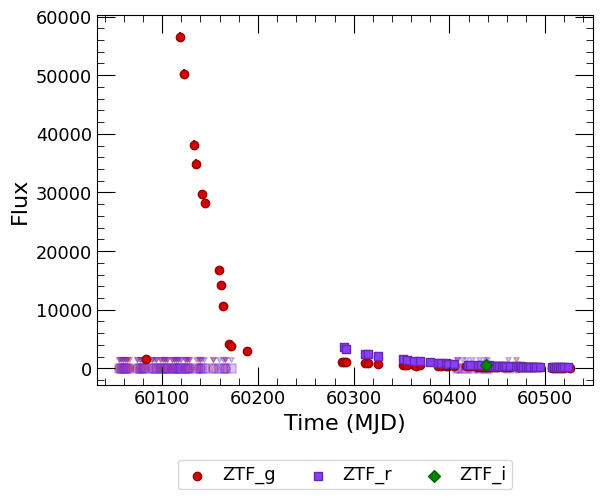

In [3]:
# plot imported LC
import matplotlib.pyplot as plt
from snapi import Formatter

photometry = transient.photometry
formatter = Formatter()
fig, ax = plt.subplots()

photometry.plot(ax, mags=False)
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()

Here, the nondetections are marked as semi-transparent upper-limits, with the detections shown opaque wih uncertainty margins. Superphot+ currently only works with detections.

Let's phase the light curve and correct for extinction:

findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: F

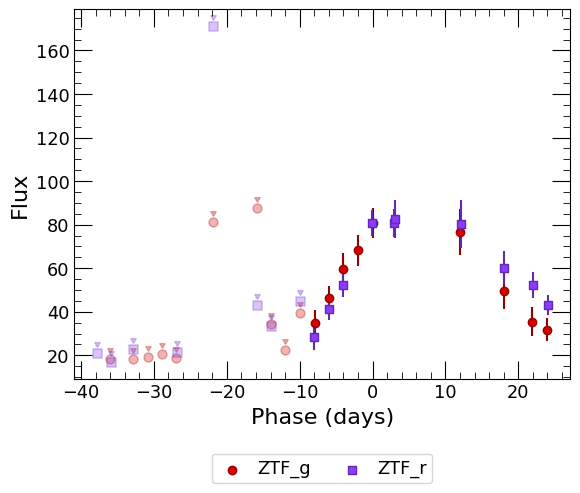

In [4]:
photometry.phase()
corr_lcs = []
for lc in photometry.light_curves:
    corr_lcs.append(
        lc.correct_extinction(coordinates=transient.coordinates)
    )
photometry = Photometry(corr_lcs)
transient.photometry = photometry

fig, ax = plt.subplots()

photometry.plot(ax, mags=False)
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()


Now let's save this file for later use:

In [5]:
# all data will be saved in root directory "data" folder
import os
from pathlib import Path

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data")
print(SAVE_DIR)

/n/holylabs/LABS/avillar_lab/Users/kdesoto/python_repos/superphot-plus/data


In [6]:
transient.save(
    os.path.join(SAVE_DIR, test_sn+".h5")
)

For our numpyro samplers, we need to pad all bands to have the same number of points. To do this, we create a padded variant of our transient photometry:

/n/holylabs/LABS/avillar_lab/Users/kdesoto/python_repos/superphot-plus/data
True
                               flux     flux_unc        mag       mag_unc  \
time                                                                        
-8 days +02:01:21.498244  34.915897     5.993395  19.820565      0.186369   
-7 days +23:35:31.502413  46.142466     5.606675  19.517871      0.131926   
-4 days +00:06:00.503999  59.490552     7.597043  19.242003      0.138650   
-2 days +01:01:29.504651  68.309326     7.181017  19.091923      0.114138   
0 days 00:27:03.499201    80.693174     6.830148  18.911031      0.091900   
12 days 01:02:11.503659   76.641501    10.743283  18.966963      0.152194   
18 days 00:06:40.498552   49.723673     8.398609  19.436715      0.183387   
21 days 22:24:42.505907   35.524829     6.581046  19.801793      0.201135   
24 days 00:05:31.499530   31.838339     5.382187  19.920747      0.183541   
1000 days 00:00:00         0.100000  1000.000000  26.400000  10857.36204

findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: F

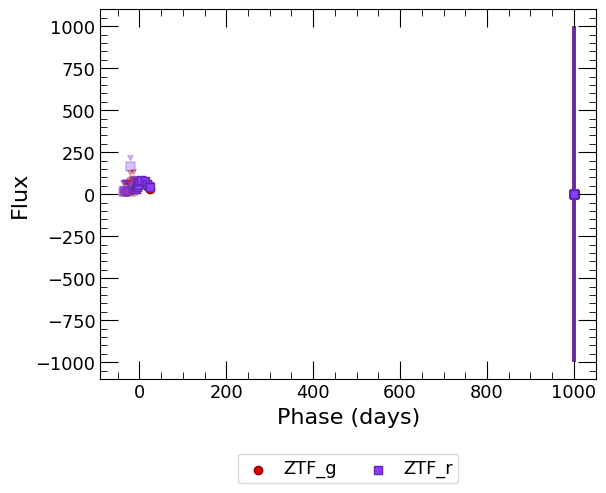

In [7]:
from astropy.time import Time
import astropy.units as u
from snapi import Transient, Formatter
import os
from pathlib import Path
import matplotlib.pyplot as plt
from snapi import Photometry

test_sn = "2022abfi"
p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data")
print(SAVE_DIR)

transient = Transient.load(
    os.path.join(SAVE_DIR, test_sn+".h5"),
)

padded_lcs = set()
fill = {'time': 1000., 'flux': 0.1, 'flux_unc': 1000., 'zpt': 23.90, 'non_detections': False}

padded_lcs = []
for lc in transient.photometry.light_curves:
    padded_lc=lc.pad(fill, 32 - len(lc.detections))
    padded_lcs.append(padded_lc)
    print(padded_lc.detections)

padded_photometry = Photometry(padded_lcs)
transient.photometry = padded_photometry
transient.save(
    os.path.join(SAVE_DIR, test_sn+"_padded.h5")
)
formatter = Formatter()
fig, ax = plt.subplots()
padded_photometry.plot(ax, mags=False)
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()


## Fitting Light Curves

There are a few sampling techniques implemented for rapid fitting of light curves:
* Nested sampling (`dynesty`) constrains the posterior space with nested ellipsoids of increasing density.
* Advanced HMC with the NUTS sampler (using `numpyro`) uses Hamiltonian Monte Carlo sampling but without U-turns to increase sampling efficiency.
* Stochastic variational inference (SVI; also using `numpyro`) approximates the marginal distributions for each fit as Gaussians, which sacrifices precision for much faster runtime. Recommended for realtime applications.

Let's use each to fit our test light curve:

In [1]:
from snapi import Transient
import os

from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.samplers.numpyro_sampler import NUTSSampler, SVISampler
from superphot_plus.priors import generate_priors
from pathlib import Path

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data")
test_sn = "2022abfi"
fn_to_fit = os.path.join(SAVE_DIR, test_sn + ".h5")
transient = Transient.load(fn_to_fit)
photometry = transient.photometry
priors = generate_priors(["ZTF_r","ZTF_g"])

2024-11-18 11:42:31.721649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731948151.746815 2313162 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731948151.754467 2313162 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
%%time

import traceback
import sys

sampler = DynestySampler(
    priors=priors,
    random_state=42,
    verbose=True
)
sampler.fit_photometry(photometry)
sampler.result.save(
    os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}.h5")
)
print("Nested sampling")
print(sampler.result.fit_parameters.head())

853it [00:06, 122.72it/s, +50 | bound: 86 | nc: 1 | ncall: 24936 | eff(%):  3.629 | loglstar:   -inf < 28.146 <    inf | logz: 12.095 +/-    nan | dlogz:  0.008 >  0.400]


Nested sampling
    A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
0  1.288951    0.015269    22.196756  -4.035558        3.636016   
1  1.372685    0.008782    16.628925  -3.537459        5.184216   
2  1.133698    0.004893    13.955313  -5.805447        3.640240   
3  1.113866    0.005468    18.956337  -4.952361        3.260375   
4  1.109475    0.009213    17.034158  -5.380129        2.800669   

   tau_fall_ZTF_r  extra_sigma_ZTF_r   A_ZTF_g  beta_ZTF_g  gamma_ZTF_g  \
0       16.873674           0.021315  1.209655    0.012031    15.156263   
1       15.669869           0.015381  1.074482    0.001442    11.129311   
2       22.123458           0.045609  0.861689    0.005921    22.900672   
3       19.709431           0.021436  0.984596    0.002154    13.452585   
4       29.124639           0.032134  1.038009    0.008607    18.382376   

   t_0_ZTF_g  tau_rise_ZTF_g  tau_fall_ZTF_g  extra_sigma_ZTF_g  
0  -5.380421        3.081777       17.329002           0.018218 

In [3]:
%%time

# use padded photometry
padded_fn = os.path.join(SAVE_DIR, test_sn + "_padded.h5")
pad_transient = Transient.load(padded_fn)
pad_photometry = pad_transient.photometry

sampler = NUTSSampler(
    priors=priors,
    pad_size=32,
    num_chains=1,
    random_state=42
)
sampler.fit_photometry(pad_photometry)
sampler.result.save(
    os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}.h5")
)
print("NUTS")
print(sampler.result.fit_parameters.head())

sample: 100%|██████████| 20000/20000 [00:52<00:00, 382.03it/s, 31 steps of size 1.52e-01. acc. prob=0.83]


NUTS
    A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
0  1.382542    0.011356    14.114581  -2.812594        3.657437   
1  1.347146    0.011842    12.739433  -2.593324        3.650500   
2  1.389519    0.015063    13.839505  -3.849799        3.781471   
3  1.385199    0.013751    14.115836  -3.572631        3.752797   
4  1.231121    0.012840    18.199902  -3.373330        4.208036   

   tau_fall_ZTF_r  extra_sigma_ZTF_r   A_ZTF_g  beta_ZTF_g  gamma_ZTF_g  \
0       18.897532           0.024442  1.523002    0.012373     7.564197   
1       21.271805           0.024614  1.415495    0.011797     8.684369   
2       27.005014           0.016217  1.227002    0.015351     7.779785   
3       25.566412           0.014399  1.216799    0.014106     7.681019   
4       18.382290           0.024728  1.400153    0.020152    15.393433   

   t_0_ZTF_g  tau_rise_ZTF_g  tau_fall_ZTF_g  extra_sigma_ZTF_g  
0  -3.551601        3.542856       15.434278           0.006254  
1  -3.451

In [4]:
%%time

# use padded photometry
padded_fn = os.path.join(SAVE_DIR, test_sn + "_padded.h5")
pad_transient = Transient.load(padded_fn)
pad_photometry = pad_transient.photometry

sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=42,
    pad_size=32
)
for i in range(5):
    sampler.fit_photometry(pad_photometry)
sampler.result.save(
    os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}.h5")
)
print("SVI")
print(sampler.result.fit_parameters.head())

Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=3/0)>
SVI
    A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
0  1.216497    0.010982    17.870985  -4.355824        3.420525   
1  1.253311    0.013030    19.235336  -3.992487        3.887599   
2  1.242307    0.012424    18.821253  -4.099963        3.743158   
3  1.192970    0.009641    17.030167  -4.593828        3.145425   
4  1.167635    0.008167    16.151531  -4.855434        2.868501   

   tau_fall_ZTF_r  extra_sigma_ZTF_r   A_ZTF_g  beta_ZTF_g  gamma_ZTF_g  \
0       21.471233           0.021033  1.144225    0.012305    17.907417   
1       24.117987           0.039521  1.237191    0.017370    21.446476   
2       23.302776           0.032794  1.208931    0.015872    20.332359   
3       19.896988           0.013915  1.087147    0.008988    15.912102   
4       18.299459           0.008836  1.027689    0.005342    13.974437   

   t_0_ZTF_g  tau_rise_ZTF_g  tau_fall_ZTF_g  extra_sigma_ZTF_g  
0  -5.403535 

Now, let's plot each fit to compare results!

/n/holylabs/LABS/avillar_lab/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/samplers/numpyro_sampler.py:224: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self._mcmc = MCMC(


0.7128226078368904
271855.62


findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: F

270748.47


findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: Font family 'Verdana' not found.
findfont: F

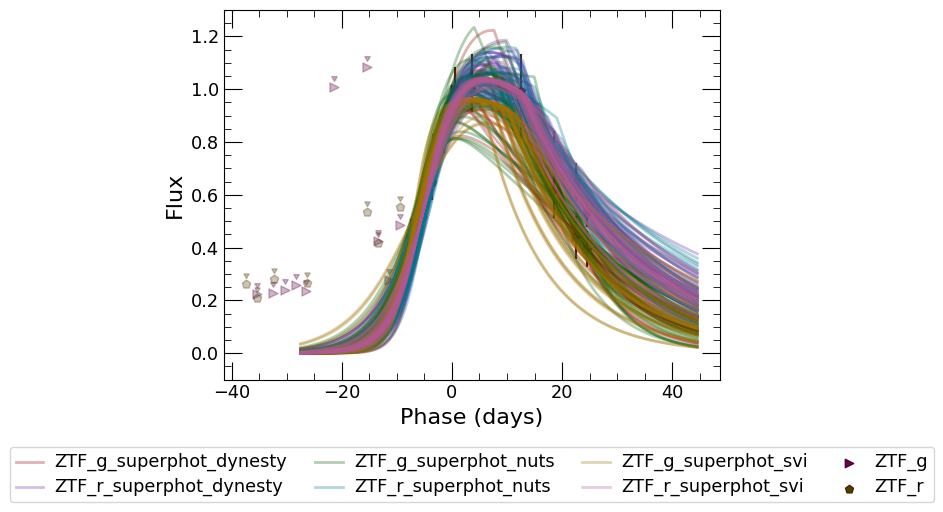

In [5]:
from superphot_plus.samplers import *
from snapi import Formatter, Transient
import matplotlib.pyplot as plt

from superphot_plus.priors import generate_priors
from pathlib import Path
import os

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data")
test_sn = "2022abfi"
fn_to_fit = os.path.join(SAVE_DIR, test_sn + ".h5")
transient = Transient.load(fn_to_fit)
photometry = transient.photometry
priors = generate_priors(["ZTF_r","ZTF_g"])

fig, ax = plt.subplots()
formatter = Formatter()
dsampler = DynestySampler(priors=priors)
nsampler = NUTSSampler(priors=priors, pad_size=32)
ssampler = SVISampler(priors=priors, pad_size=32)
for sampler in [dsampler, nsampler, ssampler]:
    sampler.load_result(
        os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}.h5")
    )
    print(sampler.result.score)
    ax = sampler.plot_fit(
        ax, formatter,
        photometry,
    )
photometry.plot(ax, formatter, mags=False)
ax.set_ylim((-0.1, 1.3))
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()


It looks like there is a tradeoff between fit time and fit quality, though there may be an issues with priors. Plotting the distribution for our differing parameters ($t0$ and $\gamma$), we get:

In [ ]:
from superphot_plus.file_utils import get_posterior_samples

params_dynesty = get_posterior_samples(
    test_sn, fits_dir=OUTPUT_DIR, sampler='dynesty'
)[0]
params_NUTS = get_posterior_samples(
    test_sn, fits_dir=OUTPUT_DIR, sampler='NUTS'
)[0]
params_svi = get_posterior_samples(
    test_sn, fits_dir=OUTPUT_DIR, sampler='svi'
)[0]
print(params_dynesty[0])

t0_idx = 3
gamma_idx = 2

plt.hist(params_dynesty[:, t0_idx], alpha=0.5, label="dynesty", density=True)
plt.hist(params_NUTS[:, t0_idx], alpha=0.5, label="NUTS", density=True)
plt.hist(params_svi[:, t0_idx], alpha=0.5, label="SVI", density=True)
plt.xlabel("t0")
plt.legend()
plt.show()

In [ ]:
from superphot_plus.surveys.surveys import Survey

ztf_priors = Survey.ZTF().priors
r_priors = ztf_priors.bands["r"]
PRIOR_GAMMA = r_priors.gamma

plt.hist(params_dynesty[:, gamma_idx], alpha=0.5, label="dynesty", density=True)
plt.hist(params_NUTS[:, gamma_idx], alpha=0.5, label="NUTS", density=True)
plt.hist(params_svi[:, gamma_idx], alpha=0.5, label="SVI", density=True)
plt.axvline(PRIOR_GAMMA.mean, c="r", label="Prior")
plt.axvline(PRIOR_GAMMA.mean + PRIOR_GAMMA.std, c="r", linestyle="dashed")
plt.axvline(PRIOR_GAMMA.mean - PRIOR_GAMMA.std, c="r", linestyle="dashed")
plt.xlabel("log gamma")
plt.xlim((0.5, 2))
plt.legend()
plt.show()

## Classification

Superphot+ uses the resulting fit parameters as input features for a multi-layer perceptron (MLP) classifier. We can call the classification functions to return probabilities of the object being each of 5 major supernova types:

In [8]:
import os
import numpy as np
from superphot_plus.trainer import SuperphotTrainer
from superphot_plus.file_utils import get_posterior_samples

test_sn = "ZTF22abvdwik" 
OUTPUT_DIR = "../examples/outputs/"
TRAINED_MODEL_FN = os.path.join(OUTPUT_DIR, "model.pt")
TRAINED_CONFIG_FN = os.path.join(OUTPUT_DIR, "model.yaml")

trainer = SuperphotTrainer(
    TRAINED_CONFIG_FN,
    OUTPUT_DIR,
    sampler="dynesty",
    model_type='MLP',
    probs_file=None,
    n_folds=1,
)
trainer.setup_model(load_checkpoint=True)
lc_probs = trainer.classify_single_light_curve(
    test_sn, OUTPUT_DIR, sampler="dynesty"
)
# Alternatively, classify from posterior samples directly
fit_params = get_posterior_samples(test_sn, OUTPUT_DIR, "dynesty")[0]
adj_params = np.delete(fit_params, [0,3], axis=1)
lc_probs2 = trainer.models[0].classify_from_fit_params(adj_params)
print(np.subtract(lc_probs, np.mean(lc_probs2, axis=0)))

../examples/outputs
[ 0.01131504  0.34618992 -0.15608865 -0.39089653  0.18947991]
